## Decision Trees

In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
from IPython.display import display
from prettytable import PrettyTable

df = pd.read_csv("../data/SFPD_data.csv")
# display(df.head())

### Multi label

In [2]:
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Split training and testing data
def split_dataset(X,Y):
    return train_test_split(X, Y, test_size=0.1, random_state=0)

#Train classifier and predict labels
def train_predict_tree_clf(X_train,Y_train,X_test):
    #Fit the classifier
    clf = DecisionTreeClassifier()
    if X_train.ndim==1:
        X_train = X_train[:,None]
    if Y_train.ndim==1:
        Y_train = Y_train[:,None]
    if X_test.ndim==1:
        X_test = X_test[:,None]
    clf.fit(X_train,Y_train)
    return clf.predict(X_test)

#Encoding categorical attributes
label_encoder = LabelEncoder()
X = label_encoder.fit_transform(df['Category'])
Y = label_encoder.fit_transform(df['PdDistrict'])

X_train, X_test, Y_train, Y_test = split_dataset(X,Y)
pred = train_predict_tree_clf(X_train,Y_train,Y_test)

X_train, X_test, Y_train, Y_test = split_dataset(X,Y)
pred = train_predict_tree_clf(X_train,Y_train,Y_test)

#We re-convert the numerical values of Y_test and pred to categorical, since we'll need them for the next step.
pred = label_encoder.inverse_transform(pred)
Y_test = label_encoder.inverse_transform(Y_test)

In [3]:
#Given the Y_test vector, the pred vector and the name of the predicted label, calculate the correctness ratio
def calculate_ratio(Y_test,pred,label,district_name=None):
    #Support dataframe with columns to compare
    df_predictions = DataFrame(np.column_stack([Y_test, pred]), columns=[label+'_Real',label+'_Pred'])
    total = len(df_predictions.index)
    
    #Calculate ratio
    num_correct_predictions = len(df_predictions[df_predictions[label+'_Real']==df_predictions[label+'_Pred']].index)
    ratio = num_correct_predictions*100.0/total
    district = '' if district_name==None else 'for district '+district_name
    print 'Fraction of correct predictions %s: %.2f%%' %(district,ratio)
    
calculate_ratio(Y_test,pred,'PdDistrict')

Fraction of correct predictions : 18.00%


### Binary

In [4]:
#We remove NAN values
districts = list(set(df['PdDistrict'].dropna()))

#Function to get the binary representation of a specific value
def get_binary_repr(value,district):
    if value==district:
        return district
    return 'NOT'+district

for district in districts:
    df_binary_districts = df
    df_binary_districts['PdDistrict_Bin'] = df_binary_districts['PdDistrict'].apply(lambda x: get_binary_repr(x,district))

    # Split training and testing data (N.B. X is the same as before)
    Y = df_binary_districts['PdDistrict_Bin']
    Y = label_encoder.fit_transform(Y)
    X_train, X_test, Y_train, Y_test = split_dataset(X,Y)
    
    #Train classifier and predict
    pred = train_predict_tree_clf(X_train,Y_train,X_test)

    #Again re-converting to categorical values
    pred = label_encoder.inverse_transform(pred)
    Y_test = label_encoder.inverse_transform(Y_test)

    #Calculate fraction of correct predictions
    calculate_ratio(Y_test,pred,'PdDistrict',district)

Fraction of correct predictions for district CENTRAL: 89.98%
Fraction of correct predictions for district NORTHERN: 87.77%
Fraction of correct predictions for district SOUTHERN: 82.00%
Fraction of correct predictions for district PARK: 94.37%
Fraction of correct predictions for district MISSION: 86.59%
Fraction of correct predictions for district TENDERLOIN: 91.13%
Fraction of correct predictions for district RICHMOND: 94.74%
Fraction of correct predictions for district TARAVAL: 92.44%
Fraction of correct predictions for district INGLESIDE: 91.06%
Fraction of correct predictions for district BAYVIEW: 89.93%


from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
import pydot
from IPython.display import Image

def show_tree(X_train,Y_train):
    clf = DecisionTreeClassifier(max_leaf_nodes=5)
    clf.fit(X_train,Y_train)
    dot_data = StringIO()  
    export_graphviz(clf, out_file=dot_data)  
    graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]
    return Image(graph.create_png()) 
    
show_tree(X_train,Y_train[:,None])

In [5]:
#Return the time of day, given the time of the crime
def get_part_of_day(time):
    hour = int(time.split(':')[0])
    if hour>=0 and hour<6:
        return 'night'
    elif hour>=6 and hour<11:
        return 'morning'
    elif hour>=11 and hour<15:
        return 'midday'
    elif hour>=15 and hour<18:
        return 'afternoon'
    else:
        return 'evening'

#Encoding and extracting features and labels
df['PartOfDay'] = df['Time'].apply(lambda x: get_part_of_day(x))
X = df.filter(items=['Category','DayOfWeek','PartOfDay'])
X_cat = label_encoder.fit_transform(X['Category'])
X_weekday = label_encoder.fit_transform(X['DayOfWeek'])
X_part_of_day = label_encoder.fit_transform(X['PartOfDay'])
X = np.column_stack((X_cat,X_weekday,X_part_of_day))
Y = label_encoder.fit_transform(df['PdDistrict'])

#Training and prediction
X_train, X_test, Y_train, Y_test = split_dataset(X,Y)
pred = train_predict_tree_clf(X_train,Y_train,X_test)
calculate_ratio(Y_test,pred,'PdDistrict')

Fraction of correct predictions : 20.37%


In [6]:
import operator

#Creating dictionary to keep track of encoded values
def get_encoding_dict(data):
    encoding_dict = {}
    le = LabelEncoder()
    data_en = le.fit_transform(data)
    for i,item in enumerate(data):
        encoding_dict[item] = data_en[i]
    return encoding_dict

#Useful function needed to repeat more events
def predict_crime(X_train,Y_train,category,weekday,daytime):
    category = category_encoding_dict[category]
    weekday = weekday_encoding_dict[weekday]
    daytime = daytime_encoding_dict[daytime]
    probabilities = predict_probabilities(X_train,Y_train,category,weekday,daytime)
    x = PrettyTable()
    x.field_names = ['District','Probability']
    for row in probabilities[:3]:
        x.add_row([row[0],str(round(row[1],2))+'%'])
    print x
    
    
#Training the classifier and predicting the probabilities
def predict_probabilities(X_train,Y_train,category,weekday,daytime):
    clf = DecisionTreeClassifier()
    clf.fit(X_train,Y_train)
    probabilities = clf.predict_proba(np.array([category,weekday,daytime]).reshape(1,-1))[0]
    probabilities = {key:probabilities[i]*100
                     for key, value in district_encoding_dict.iteritems()
                     for i,label in enumerate(clf.classes_)
                     if value == label}
    return sorted(probabilities.items(),key=operator.itemgetter(1),reverse=True)

#Before encoding, get encoding dictionaries
category_encoding_dict = get_encoding_dict(df['Category'])
weekday_encoding_dict = get_encoding_dict(df['DayOfWeek'])
daytime_encoding_dict = get_encoding_dict(df['PartOfDay'])
district_encoding_dict = get_encoding_dict(df['PdDistrict'])

# Predict
predict_crime(X_train,Y_train,'PROSTITUTION','Monday','evening')
predict_crime(X_train,Y_train,'GAMBLING','Wednesday','midday')
predict_crime(X_train,Y_train,'ARSON','Sunday','morning')

+----------+-------------+
| District | Probability |
+----------+-------------+
| MISSION  |    66.18%   |
| NORTHERN |    11.66%   |
| CENTRAL  |    7.58%    |
+----------+-------------+
+-----------+-------------+
|  District | Probability |
+-----------+-------------+
| INGLESIDE |    22.73%   |
|  NORTHERN |    18.18%   |
|  BAYVIEW  |    18.18%   |
+-----------+-------------+
+-----------+-------------+
|  District | Probability |
+-----------+-------------+
|  BAYVIEW  |    30.43%   |
| INGLESIDE |    17.39%   |
|  SOUTHERN |    13.04%   |
+-----------+-------------+


## Clustering

In [7]:
# Filter out Prostitution only
df = df[df['Y']!=90]
df_kmeans = df[df['Category']=='PROSTITUTION']
df_kmeans = df_kmeans.filter(items=['Category','X','Y'])

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline
import geoplotlib
from geoplotlib.utils import BoundingBox
from geoplotlib.colors import ColorMap

def kde_plot(df_geo_data_plot,geo_data_bounding):
    '''Plot the KDE on a map'''
    
    # Create a dictionary and put crime's coordinates as a separate key,value pair and plot the KDE
    geo_data_for_plotting = {"lat": [float(el) for el in list(df_geo_data_plot['Y'])],
                             "lon": [float(el) for el in list(df_geo_data_plot['X'])]}
    
    geoplotlib.kde(geo_data_for_plotting,bw=2,binsize=0.5,cmap='jet')
    bbox = BoundingBox(north=max(geo_data_bounding['lat']),
                       west=min(geo_data_bounding['lon']),
                       south=min(geo_data_bounding['lat']),
                       east=max(geo_data_bounding['lon']))
    geoplotlib.set_bbox(bbox)
    geoplotlib.inline()

def dot_plot(df_geo_data_plot,geo_data_bounding,n_clusters):
    '''Plot the dotplot on a map'''
    colors = ['red', 'green', 'blue','black','green', 'green', 'blue','black','black','green']
    
    # Create a dictionary and put each crime's coordinates as a separate key,value pair and plot the KDE
    geo_dict = {}
    for cluster in range(n_clusters):
        geo_data_for_plotting = {"lat": [float(el) for el in list(df_kmeans[df_kmeans[str(n_clusters)+'_clusters']==cluster]['Y'])], 
                                 "lon": [float(el) for el in list(df_kmeans[df_kmeans[str(n_clusters)+'_clusters']==cluster]['X'])]}
        geo_dict[cluster] = geo_data_for_plotting

    for i,cluster in enumerate(list(df_geo_data_plot[str(n_clusters)+'_clusters'].unique())):
        geoplotlib.dot(geo_dict[cluster], color=colors[i], point_size=3)

    bbox = BoundingBox(north=max(geo_data_bounding['lat']),
                       west=min(geo_data_bounding['lon']),
                       south=min(geo_data_bounding['lat']),
                       east=max(geo_data_bounding['lon']))
    geoplotlib.set_bbox(bbox)
    geoplotlib.inline()   

# Create a dictionary and put all crime's coordinates for a standardized bounding box
geo_data_for_bounding_box = {"lat": [float(el) for el in list(df['Y'])],
                             "lon": [float(el) for el in list(df['X'])]}

# Plot the KDE on the map for PROSTITUTION data
kde_plot(df_kmeans,geo_data_for_bounding_box)

('smallest non-zero count', 4.4777898101688105e-09)
('max count:', 46.996545704077626)


In [9]:
from sklearn.cluster import KMeans

# Assign X and Y to K-means classifier
X = np.array(df_kmeans[['X','Y']])

# Initialize the KMeans algorithm and fit
def k_means_func(n_clusters):
    clf = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    return clf

# Create a cluster reference for each K
for i in range(2,11):
    df_kmeans[str(i)+'_clusters'] = pd.Series(k_means_func(i).labels_, index=df_kmeans.index)

# Plot the 3 maps for K = 2,3 and 4
for i in range(2,5):
    dot_plot(df_kmeans,geo_data_for_bounding_box,i)

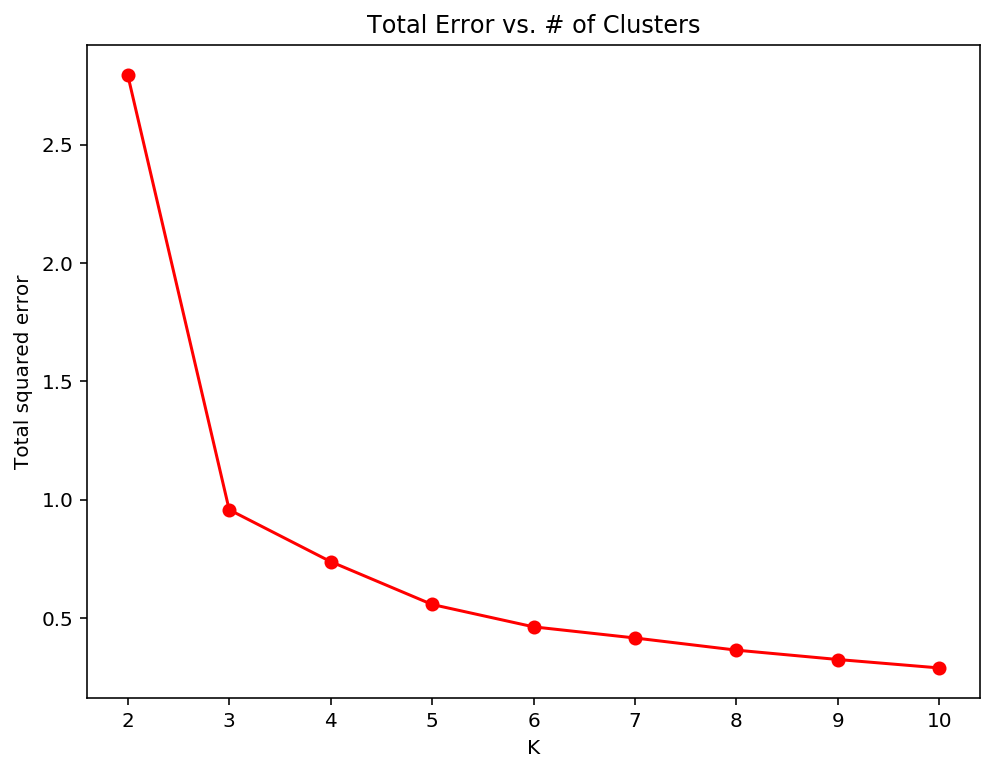

In [10]:
%config InlineBackend.figure_format = 'retina'

def squared_errors(k):
    clf = k_means_func(k)
    return clf.inertia_

ks = range(2,11)
errors = [squared_errors(k) for k in ks]
plt.figure(figsize=(8,6))
plt.plot(ks, errors,'r-o')
plt.xticks(ks)
plt.xlabel("K")
plt.ylabel("Total squared error")
plt.title("Total Error vs. # of Clusters")
plt.show()

Another way of estimating the right number of clusters in a $K$-means problem is _stability analysis_. The idea is the following:
- For each $K = 2, \ldots,10$ generate $N = 10$ clusterings based on random 50% of data (or some other fraction of data/bootstrap).
- Divide the space up into an e.g. 20 by 20 grid, and give each gridpoint an index $i$ in the range 1-400.
- Now represent each clustering as a vector $\mathbf{c}^K$, which where the $j$th entry $c_j^K$ is given by the number of centroids in that gridpoint. Most of the entries will be zero, and we have that $\sum_{j = 1}^{400} c_j^K = K$.
> Each vector $\mathbf{c}^K$ has 400 entries, corresponding to the 400 cells in which we divide our 20x20 grid into. Each entry lists the number of centroids in that part of the grid.
- We now define _stability_ for some value of $K$ as average pairwise similarity of the $N$ clusterings, where the similarity between clustering $i$ and $j$ is the cosine distance between clustering vectors $\mathbf{c}^K(i)$ and $\mathbf{c}^K(j)$.
>  We have $N=10$ vectors for each $K = 2, \ldots,10$. For each value of $K$, we define stability. We define stability as the average pairwise similarity between the clusterings. The more similar the clusterings, the more stable is $K$.
- We now say that the right $K$ maximizes stability.
* Explain why stability should help you find the right number of clusters.
> The stability of each $K$, $K$ being the number of clusters we choose to identify, is an indicator of how the $N$ different clusterings, generated with a sample of 50% of the data, will be similar between each other. In our concrete case, we can see from the maps plotted above that $K=3$ seems to us a reasonable choice to cluster the locations. After the analysis, we expect $K=3$ to be very stable because if we clustered 10 times a sample of 50% of the data, we would expect similar results to the one we plotted.